### Import Dataset

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

/Users/apple/venv/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
df = pd.read_csv('commit_data.csv')
print(df.head())
print(df.shape)

# convert string to list
from ast import literal_eval

df['categories'] = df['categories'].apply(lambda x: literal_eval(x))
print(type(df['categories'].values[0]))
df['categories'].values[0]

   Unnamed: 0 commit id                                         categories  \
0           0   0b9ea98                         ['Testing', 'Feature Add']   
1           1   980d9f8                                    ['Refactoring']   
2           2   e9d5060              ['Testing', 'Bug fix', 'Feature Add']   
3           3   a63639b  ['Testing', 'Maintenance', 'Build', 'Feature A...   
4           4   a611d64                   ['Module Move', 'Module Remove']   

                                      commit_message  
0  [CALCITE-1124] Add TIMESTAMPADD, TIMESTAMPDIFF...  
1  Move code from JdbcImplementor and JdbcRules t...  
2  [CALCITE-968] Stream-to-relation and stream-to...  
3  [CALCITE-912] Add Avatica OpenConnectionReques...  
4  [CALCITE-296] Re-organize package structure;\n...  
(925, 4)
<class 'list'>


['Testing', 'Feature Add']

### Multilabel Transform

In [3]:
# tag counts
def get_tag_counts(df):
    
    tags_counts = Counter()

    for tags in df['categories'].values:
        for tag in list(tags):
            tags_counts[tag] += 1

    most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:]

    for item in most_common_tags:
        print(item[0], ":", item[1])
        
    return tags_counts

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

tags_counts = get_tag_counts(df)

y = df['categories'].values
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_new = mlb.fit_transform(y)

target_columns = mlb.classes

for index, item in enumerate(target_columns):
    df[item] = y_new[:, index]

Maintenance : 443
Testing : 343
Feature Add : 184
Bug fix : 146
Clean up : 108
Documentation : 100
Build : 68
Refactoring : 64
Indentation : 30
Token Replace : 20
Cross : 15
Source Control : 10
Legal : 10
Debug : 8
Module Remove : 6
Module Move : 5
Rename : 4
Merge : 3
Versioning : 2
Module Add : 1
Initialization : 1
Internationalization : 1


### Merge Category

In [5]:
# drop categories with too fewer commits
data = df[(df['Module Add']!=1) & (df['Module Move']!=1) & (df['Module Remove']!=1) & (df['Source Control']!=1) & (df['Internationalization']!=1) & (df['Merge']!=1) & (df['Initialization']!=1)]
data = data.reset_index(drop=True)
print(data.shape)
tags_counts = get_tag_counts(data)

(899, 26)
Maintenance : 440
Testing : 338
Feature Add : 184
Bug fix : 146
Clean up : 108
Documentation : 99
Refactoring : 64
Build : 63
Indentation : 30
Token Replace : 20
Cross : 15
Legal : 9
Debug : 8
Rename : 4
Versioning : 2


In [6]:
target_columns

['Bug fix',
 'Build',
 'Clean up',
 'Cross',
 'Debug',
 'Documentation',
 'Feature Add',
 'Indentation',
 'Initialization',
 'Internationalization',
 'Legal',
 'Maintenance',
 'Merge',
 'Module Add',
 'Module Move',
 'Module Remove',
 'Refactoring',
 'Rename',
 'Source Control',
 'Testing',
 'Token Replace',
 'Versioning']

In [7]:
# merge cateogories to - 'corrective', 'perfective', 'other', 'feature_addition' and 'debug'
def create_corrective(row):
    if row['Bug fix'] == 1 or row['Maintenance'] == 1 or row['Build'] == 1:
        return 1
    else:
        return 0
    
def create_perfective(row):
    if row['Refactoring'] == 1 or row['Documentation'] == 1 or row['Clean up'] == 1 or row['Token Replace'] == 1 or row['Indentation'] == 1:
        return 1
    else:
        return 0
    
def create_other(row):
    if row['Versioning'] == 1 or row['Rename'] == 1 or row['Legal'] == 1 or row['Cross'] == 1:
        return 1
    else:
        return 0

def create_feature_additon(row):
    if row['Feature Add'] == 1:
        return 1
    else:
        return 0

def create_debug(row):
    if row['Testing'] == 1 or row['Debug'] == 1:
        return 1
    else:
        return 0

In [8]:
data['corrective'] = data.apply(lambda row: create_corrective(row), axis = 1)
data['perfective'] = data.apply(lambda row: create_perfective(row), axis = 1)
data['other'] = data.apply(lambda row: create_other(row), axis = 1)
data['feature addition'] = data.apply(lambda row: create_feature_additon(row), axis = 1)
data['debug'] = data.apply(lambda row: create_debug(row), axis = 1)

In [9]:
new_target = ['corrective','perfective','feature addition']

In [10]:
data = data[(data['other']!=1)]
data = data.reset_index(drop=True)
print(data.shape)

(869, 31)


In [11]:
new_tag_counts = get_tag_counts(data)

Maintenance : 432
Testing : 332
Feature Add : 181
Bug fix : 145
Clean up : 107
Documentation : 99
Refactoring : 64
Build : 61
Indentation : 29
Token Replace : 18
Debug : 8


In [14]:
print('corrective:', data[data['corrective'] == 1].shape[0])
print('perfective:', data[data['perfective'] == 1].shape[0])
print('other:', data[data['other'] == 1].shape[0])
print('feature addition:', data[data['feature addition'] == 1].shape[0])
print('debug:', data[data['debug'] == 1].shape[0])

corrective: 571
perfective: 285
other: 0
feature addition: 181
debug: 337


In [15]:
data.columns

Index(['Unnamed: 0', 'commit id', 'categories', 'commit_message', 'Bug fix',
       'Build', 'Clean up', 'Cross', 'Debug', 'Documentation', 'Feature Add',
       'Indentation', 'Initialization', 'Internationalization', 'Legal',
       'Maintenance', 'Merge', 'Module Add', 'Module Move', 'Module Remove',
       'Refactoring', 'Rename', 'Source Control', 'Testing', 'Token Replace',
       'Versioning', 'corrective', 'perfective', 'other', 'feature addition',
       'debug'],
      dtype='object')

### Label Statistics

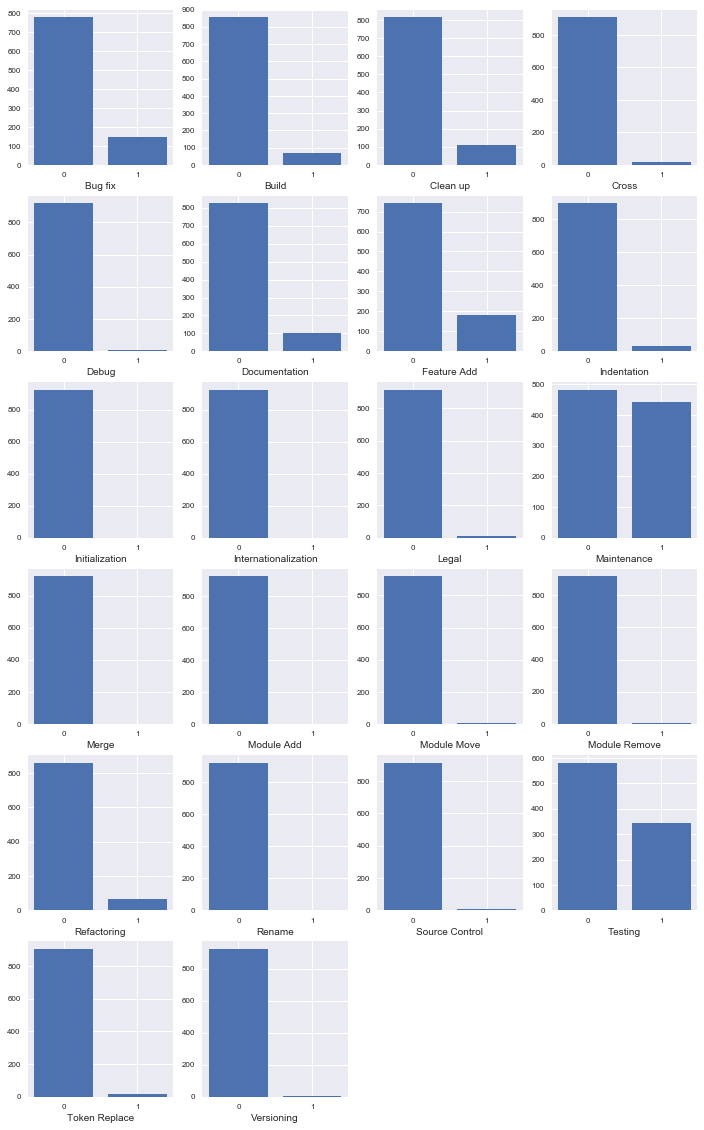

In [40]:
# class imbalance
sns.set(font_scale = 0.8)
plt.figure(figsize=(12,20))

for index, label in enumerate(target_columns):
    #print('================================================================')
    #print(index, label)
    #print(df[label].value_counts()[0], ' ',df[label].value_counts()[1])
    
    binary_class = df[label].value_counts()
    
    plt.subplot(6,4,index+1)
    plt.bar(binary_class.index, binary_class.values)
    plt.xticks([0,1])
    plt.xlabel(label, fontsize=10)

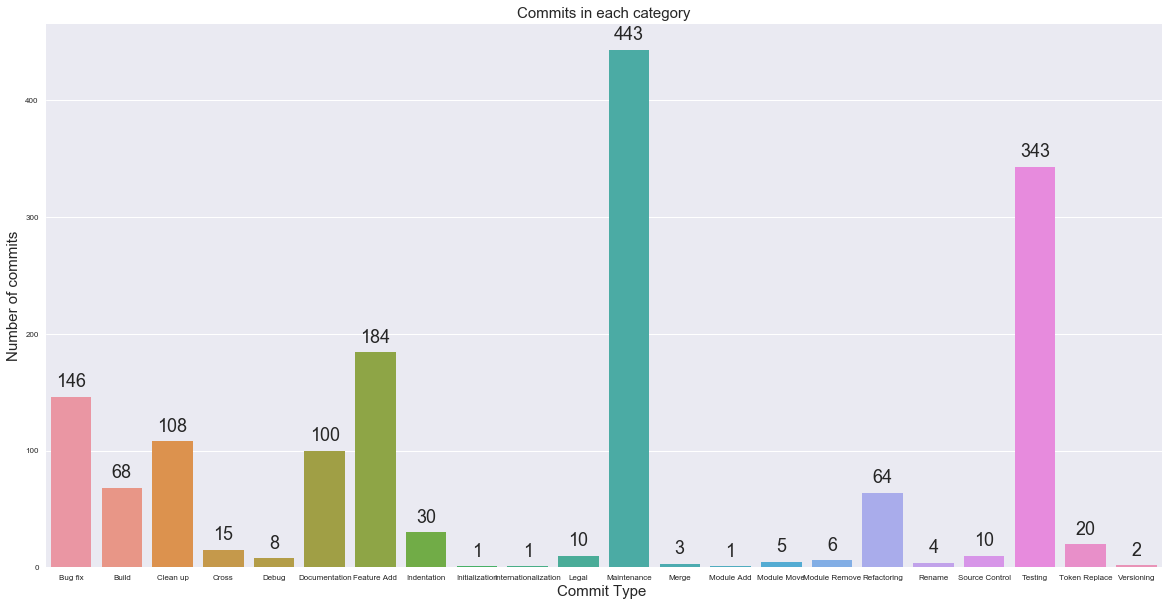

In [41]:
# number of commits of each labels
sns.set(font_scale = 0.8)
plt.figure(figsize=(20,10))
ax= sns.barplot(target_columns, df[target_columns].sum().values)
plt.title("Commits in each category", fontsize=15)
plt.ylabel('Number of commits', fontsize=15)
plt.xlabel('Commit Type ', fontsize=15)
#adding the text labels
rects = ax.patches
labels = df[target_columns].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

1    467
2    318
3    103
4     27
5      8
6      2
dtype: int64


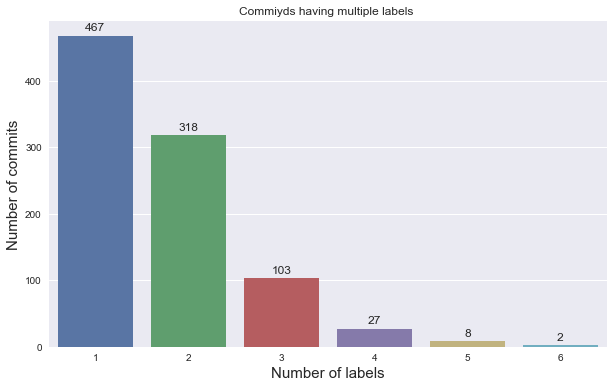

In [42]:
# number of commits have multiple labels

rowSums = df[target_columns].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[0:]
print(multiLabel_counts)

sns.set(font_scale = 1)
plt.figure(figsize=(10,6))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Commiyds having multiple labels ")
plt.ylabel('Number of commits', fontsize=15)
plt.xlabel('Number of labels', fontsize=15)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

### Message Preprocessing

##### (i) Remove git-svn-id: 
e.g. git-svn-id: https://svn.apache.org/repos/asf/commons/proper/collections/trunk@1492866 13f79535-47bb-0310-9956-ffa450edef68
##### (ii) Remove Issue Number : e.g. [CALCITE-968]  [COMPRESS-392]
##### (iii) Remove Created by MOE - 
eg. Created by MOE: https://github.com/google/moe
MOE_MIGRATED_REVID=160142836
##### (iv) Remove Developer name
e.g. 344 [] User-defined aggregate functions with more than one parameter (hzyuemeng1)
##### (v) Remove http and email address
##### (vi) Other filter
- Authors
- Reviewers
- [...]
- digitial
- special character
#### Spell Checking - remove project name/class name/method name
Three Options:
1. keep all wrong words
2. remove all wrong words
3. replace wrong words with some new words

In [16]:
import nltk
from enchant.checker import SpellChecker
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
from nltk.corpus import stopwords
from ast import literal_eval
import re
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# message filter
GIT_SVN_RE = re.compile('git-svn-id:.*\n')
issue_number_re = re.compile('[A-Za-z]+[-]\d+')
created_by_moe = re.compile('Created by MOE:.*\n')
MOE_ID = re.compile('MOE_MIGRATED_REVID=.*\n')
developer_name_re = re.compile('\(.*\)\n')
HTTP_RE = re.compile('(http|https):.*\n')
EMAIL_RE = re.compile('[a-zA-Z0-9]+@[a-zA-Z0-9]+\.[a-zA-Z0-9-.]+')
Other_RE = re.compile('(Author|Authors|Reviewers|Reviewer).*\n')
Bracket_RE = re.compile('\[.*\]')

special_character_re = re.compile(r'[?|!|\'|"|#]')
punctuation = re.compile(r'[.|,|)|(|\|/]')
break_line_re = re.compile('\n')
digital = re.compile('[0-9]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z ]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = GIT_SVN_RE.sub('',text)
    text = issue_number_re.sub('',text)
    text = created_by_moe.sub('',text)
    text = MOE_ID.sub('',text)
    text = developer_name_re.sub('\n', text)
    text = HTTP_RE.sub('\n', text)
    text = EMAIL_RE.sub('\n',text)
    text = Other_RE.sub('', text)
    text = Bracket_RE.sub('', text)
    
    text = text.lower() # lowercase text
    text = special_character_re.sub('',text)
    text = punctuation.sub(' ',text)
    text = text.strip()
    text = break_line_re.sub(' ',text) # remove all \n
    text = digital.sub('',text)
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    
    text = ' '.join([x for x in text.split() if x and x not in STOPWORDS]) # delete stopwords from text
    return text

# function of wrong spelling words
def check_wrong_words(commit_message):
    chkr = SpellChecker("en_US")
    wrong_words = []
    for index, text in enumerate(commit_message):
        chkr.set_text(text)
        for err in chkr:
            if err.word not in wrong_words:
                wrong_words.append(err.word)
            #   print(index, err.word)
    return wrong_words


def remove_noise_words(message_array, wrong_words):
    res = []
    for text in message_array:
        text = ' '.join([x for x in text.split() if x and x not in wrong_words])
        res.append(text)
    return res

def replace_nosie_words_with_sth(message_array, wrong_words):
    res = []
    for text in message_array:
        # replace wrong word with something
        new_text = []
        for x in text.split():
            if x and x in wrong_words:
                new_text.append('something')
            else:
                new_text.append(x)

# stemming
def stemming(message_array):
    
    stemmer = SnowballStemmer("english") # Choose a language
    # stemmer.stem("countries")
    for index, text in enumerate(message_array):
    #     print(index, df['cmt_msg'][index])
        message_array[index] = ' '.join([stemmer.stem(x) for x in text.split()])
    #     print(index, df['cmt_msg'][index])
    
    return message_array

[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/apple/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
def message_processing(message_array, remove_noise = True):
    
    # filtering
    message_array = [text_prepare(line) for line in message_array]
    #for index, line in enumerate(message_array):
    #    if index < 10:
    #        print(index, line)
    
    # remove noise word
    wrong_words = check_wrong_words(message_array)
    remove_noise_message = remove_noise_words(message_array, wrong_words)
    original_commit_message = np.copy(message_array)
    if remove_noise == True:
        message_array = remove_noise_message
    else:
        message_array = original_commit_message
    
    #stemming
    message_array = stemming(message_array)
    
    return message_array

In [19]:
message_array = message_processing(df.commit_message, remove_noise=False)

print(message_array[0:10])

['add timestampadd timestampdiff function close apach calcit'
 'move code jdbcimplementor jdbcrule new class sqlimplementor'
 'streamtorel streamtostream join rule transform delta scan constantt empti fix nullpointerexcept pruneemptyrul'
 'add avatica openconnectionrequest goal pass connect properti info remot avatica driver correspond serversid connect chang includ meta explicit open connect new openconnect call client decid connect id implicit creation unknown connect gone jdbcmeta default connect gone method extend connect id correspond various servic request carri connect id unrel use test meaning error messag remot driver'
 'reorgan packag structur name convent planner rule chang renam file delet obsolet file content chang'
 'infer collat project use monoton close apach incubatorcalcit'
 'add piglet subset pig latin top calcit algebra includ parser distinct order limit group command incomplet nest foreach command add test base exampl piglatin refer'
 'revert chang introduc rev par

### TD-IDF

In [139]:
from scipy import sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

def tfidf_features(X):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), norm='l2')
    
    X = tfidf_vectorizer.fit_transform(X)
    
    return X,tfidf_vectorizer.vocabulary_

def td_idf_split(df, target_columns):
    X, y = df['commit_message'].values, df[target_columns].values
    X_tfidf, tfidf_vocab = tfidf_features(X)
    tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.10, random_state=42)
    
    return X_train, X_test, y_train, y_test

### Multilable Classifier

In [140]:
#data['commit_message'] = message_processing(data['commit_message'].values)

X_train, X_test, y_train, y_test = td_idf_split(data, new_target)

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

def print_evaluation_scores(y_test, predicted):
    
    print('Accuracy:', accuracy_score(y_test, predicted))
    print('F1-score macro:', f1_score(y_test, predicted, average='macro'))
    print('F1-score micro:', f1_score(y_test, predicted, average='micro'))
    print('F1-score weighted:', f1_score(y_test, predicted, average='weighted'))

#### Naive Bayesian

In [31]:
classifier = BinaryRelevance(GaussianNB())
# train
classifier.fit(X_train, y_train)
# predict
y_pred = classifier.predict(X_test)
# metrics
print_evaluation_scores(y_test, y_pred)

Accuracy: 0.26436781609195403
F1-score macro: 0.46689518132141083
F1-score micro: 0.5158371040723982
F1-score weighted: 0.5290653193268148


#### Classifier Chain

In [142]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression())
# Training logistic regression model on train data
classifier.fit(X_train, y_train)
# predict
y_pred = classifier.predict(X_test)
# metrics
print_evaluation_scores(y_test, y_pred)

Accuracy: 0.5057471264367817
F1-score macro: 0.3329065300896287
F1-score micro: 0.6354166666666667
F1-score weighted: 0.5031888299493933


#### Label Powerset

In [141]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression(penalty='l1', C=6.0, solver='saga', random_state=0))
# train
classifier.fit(X_train, y_train)
# predict
predictions = classifier.predict(X_test)
# metrics
print_evaluation_scores(y_test, y_pred)

KeyboardInterrupt: 

#### ML-KNN

In [34]:
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix

classifier_new = MLkNN(k=55)
# Note that this classifier can throw up errors when handling sparse matrices.
X_train = lil_matrix(X_train).toarray()
y_train = lil_matrix(y_train).toarray()
X_test = lil_matrix(X_test).toarray()
# train
classifier_new.fit(X_train, y_train)
# predict
y_pred = classifier_new.predict(X_test)
# metrics
print_evaluation_scores(y_test, y_pred)

Accuracy: 0.41379310344827586
F1-score macro: 0.42176101957470785
F1-score micro: 0.6030927835051546
F1-score weighted: 0.5321912063227097


#### logistic Regression

In [35]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

lr = LogisticRegression(penalty='l2', C=6.0, solver='saga', random_state=0, max_iter=20)
ovr = OneVsRestClassifier(lr)
classifier_tfidf =ovr.fit(X_train, y_train)
y_pred = classifier_tfidf.predict(X_test)

print_evaluation_scores(y_test, y_pred)

Accuracy: 0.5
F1-score macro: 0.5361508215503997
F1-score micro: 0.6581632653061225
F1-score weighted: 0.6200334196451878


#### Logistic Regresson for each category

In [55]:
for i in range(y_train.shape[1]):
    lr = LogisticRegression(penalty='l2', C=6.0, solver='saga', random_state=0, max_iter=20)
    ovr = OneVsRestClassifier(lr)
    classifier_tfidf =ovr.fit(X_train, y_train[:, i])
    y_pred = classifier_tfidf.predict(X_test)
    
    print('==========================================================')
    print_evaluation_scores(y_test[:,i], y_pred)

Accuracy: 0.6896551724137931
F1-score macro: 0.6164897959183673
F1-score micro: 0.6896551724137931
F1-score weighted: 0.6626995073891625
Accuracy: 0.735632183908046
F1-score macro: 0.6501748251748252
F1-score micro: 0.735632183908046
F1-score weighted: 0.7117836186801705
Accuracy: 0.8103448275862069
F1-score macro: 0.6209150326797386
F1-score micro: 0.8103448275862069
F1-score weighted: 0.771842836751559


### Fine-tuning Model

#### TD-IDF + logistic regression

Best Parameters:

- tf-idf

max_df 1.0

min_df 0.0

ngram (1,2) -  we dont remove those wrong words

norm l2

max_features - use all

- split

split 0.1 for test set

- lr

penalty - l1

C - 2.5 for frequency features 6.5 for binary features

max_iter - > 1000


In [173]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

def td_idf_model(df, target_columns, classifier, parameters, multi = False):

    X, y = df['commit_message'].values, df[target_columns].values
    
    # td-idf
    tfidf_vectorizer = TfidfVectorizer(max_df = parameters['max_df'],
                                       min_df = parameters['min_df'],
                                       max_features = parameters['max_features'],
                                       ngram_range=parameters['ngram'],
                                       norm=parameters['norm'],
                                       binary = parameters['binary'],
                                       use_idf = parameters['use_idf'],
                                       smooth_idf = parameters['smooth_idf'],
                                       sublinear_tf = parameters['sublinear_tf'])
    
    X_tfidf = tfidf_vectorizer.fit_transform(X)
    tfidf_vocab = tfidf_vectorizer.vocabulary_
    tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}
    
    # splite test and trainset
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=parameters['split_size'], random_state=42)
    print(X_train.shape)
    
    # model
    if multi == False:
        ovr = OneVsRestClassifier(classifier)
        classifier_tfidf =ovr.fit(X_train, y_train)
    else:
        classifier_tfidf = classifier.fit(X_train, y_train)
    
    #print(classifier)
        
    y_pred = classifier_tfidf.predict(X_test)

    print_evaluation_scores(y_test, y_pred)

In [134]:
parameters = {'max_df':1.0, 'min_df':0.0, 'ngram':(1,2), 'max_features':None, 'norm':'l2', 
              'binary': False,'use_idf':True, 'smooth_idf':True, 'sublinear_tf':False, 
              'split_size':0.1,'lr_penalty':'l1', 'lr_C':6.5, 'l1ratio':None, 'lr_maxiter':1000, 'lr_class_weight':None}

 
for lr_C in [2.5]:
    print('==================================================')
    print('parameter:', lr_C)
    parameters['lr_C'] = lr_C
    
    lr = LogisticRegression(penalty=parameters['lr_penalty'], C=parameters['lr_C'], solver='saga', l1_ratio = parameters['l1ratio'], 
                            random_state=0, max_iter=parameters['lr_maxiter'], class_weight=parameters['lr_class_weight'])
    
    td_idf_model(data, new_target,lr, parameters)

parameter: 2.5
(782, 17992)
Accuracy: 0.5977011494252874
F1-score macro: 0.5671957671957673
F1-score micro: 0.7272727272727272
F1-score weighted: 0.6759788359788361


#### TD-IDF + Random Forest

**Best Parameters**:

n_estimators 80

max_depth 40

max_features 4000

criterion 'gini

min_samples_leaf 1

max_leaf_ndoes None

In [147]:
from sklearn.ensemble import RandomForestClassifier

In [280]:
parameters = {'max_df':1.0, 'min_df':0.0, 'ngram':(1,2), 'max_features':None, 'norm':'l2', 
              'binary': False,'use_idf':True, 'smooth_idf':True, 'sublinear_tf':False, 'split_size':0.1}

 
for n_estimators in [80]:
    for max_depth in [40]:
        for max_leaf_nodes in [100]:
            print('==================================================')
            print('parameter:',max_leaf_nodes)
            #parameters['lr_C'] = lr_C
            clf = RandomForestClassifier(n_estimators=80, 
                                         max_depth=40,
                                         max_features = 4000,
                                         criterion = 'gini',
                                         #min_samples_split = 0.1,
                                         min_samples_leaf = 1,
                                         max_leaf_nodes = None,
                                         random_state=0)
            td_idf_model(data, new_target, clf, parameters, multi=True)

parameter: 100
(782, 17992)
Accuracy: 0.5862068965517241
F1-score macro: 0.5273611595550906
F1-score micro: 0.6839378238341969
F1-score weighted: 0.6499681653849773
